In [3]:
#https://github.com/derekbanas/TimeSeriesAnalysis/blob/main/Time%20Series%20Forecasting%208.ipynb
#https://www.youtube.com/watch?v=twHaVc_H7ik
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import mplfinance as mpf
%matplotlib inline
import statsmodels.api as sm
import seaborn as sns

#import chart_studio.plotly as py
#import plotly.express as px
#import plotly.graph_objects as go

#import cufflinks as cf # Connects Plotly to Pandas
# Makes Plotly work in your Notebook
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)
#cf.go_offline()

import requests # Get URL data
from bs4 import BeautifulSoup # Manipulate URL data
import json

# Used to measure whether our data is stationary
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

import warnings
warnings.filterwarnings('ignore')

In [194]:
gameName = "S"

In [40]:
from statsmodels.tsa.api import VAR

def readData(gamenName): 
    df = pd.read_excel(gamenName, 
                        index_col='datetime', parse_dates=True)

    df = df.sort_index(ascending=True)

    #gdp_df = gdp_df.dropna()
    #gdp_df = gdp_df.asfreq('Q') # Change frequency to quarterly

    ax = df['peakplayer'].plot(legend=True, figsize=(16,8))

    # Does sentscore influence peakplayer?
    df['sentscore'] = df['sentscore']  *20000 # just to see the scale
    df['sentscore'].plot(legend=True)

    return df
    df.tail(5)


,sentscore,peakplayer
datetime,,
2020-01-01,14278.110561,16769
2020-01-02,19425.903333,14486
2020-01-03,19673.357813,14241
2020-01-04,20194.990024,15807
2020-01-05,16396.264295,15426
...,...,...
2020-12-27,20970.518941,20029
2020-12-28,16240.625185,19177
2020-12-29,22251.241163,19176


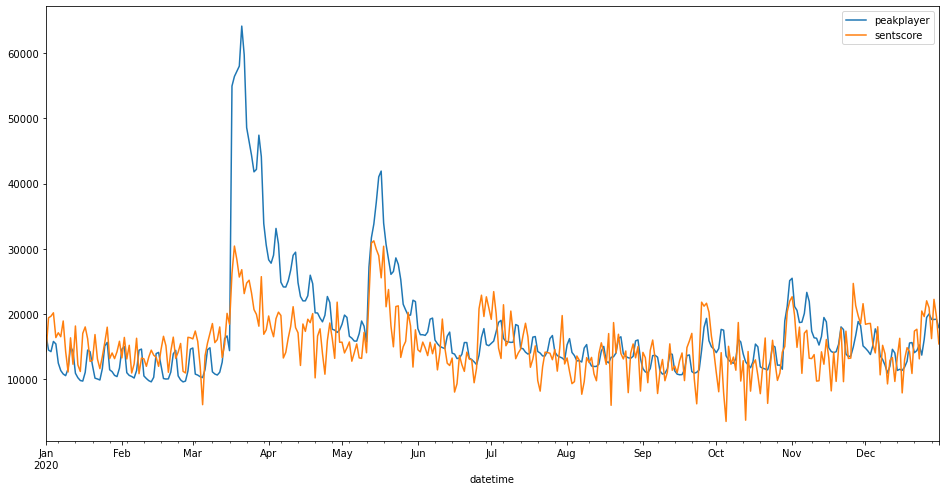

In [41]:
readData("consolidatedStellaris-NotPredicted.xls")

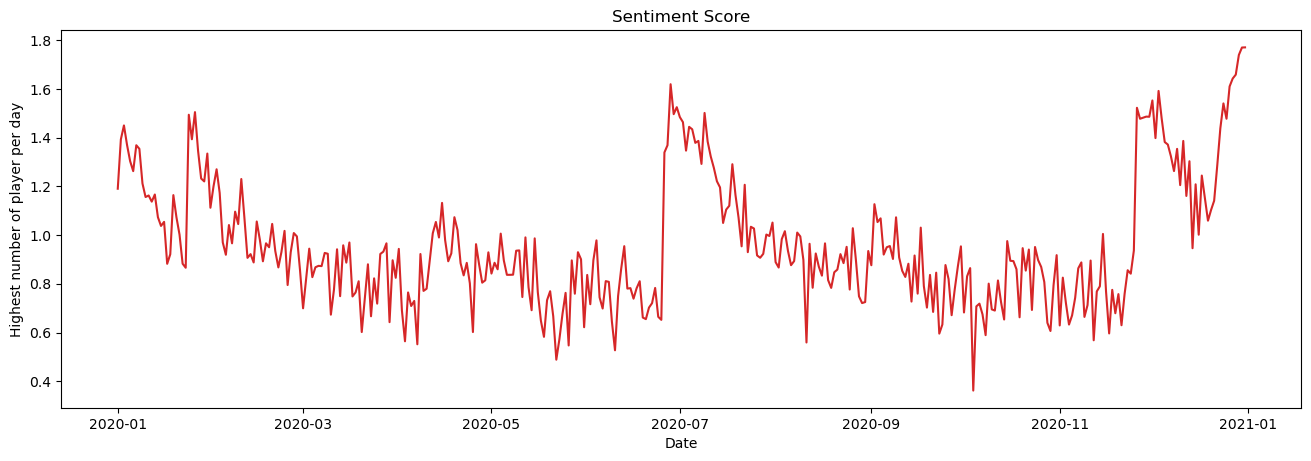

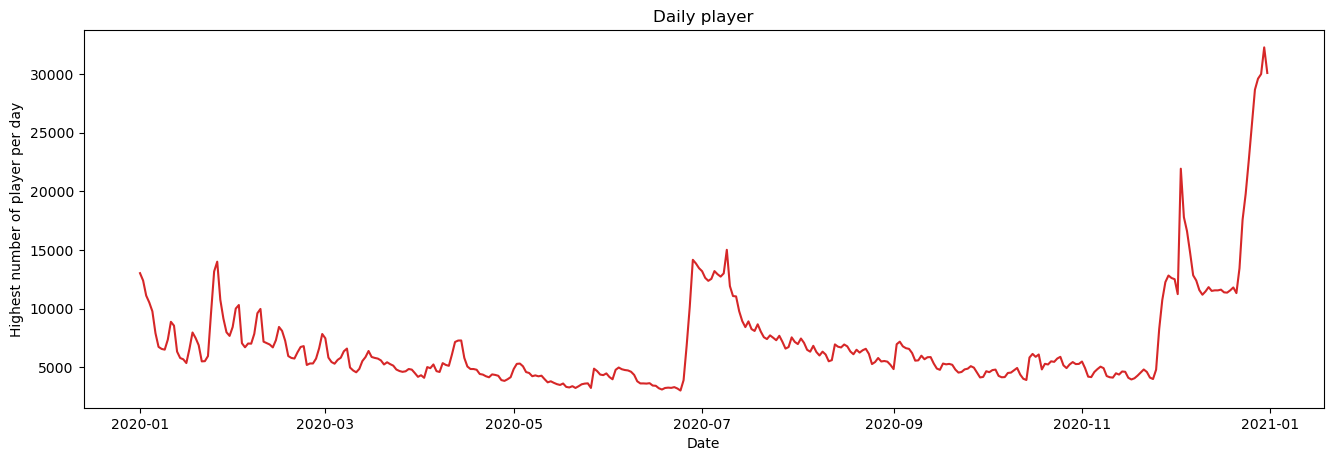

In [24]:
#TEMPORARY
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot

#https://www.analyticsvidhya.com/blog/2021/08/granger-causality-in-time-series-explained-using-chicken-and-egg-problem/
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Highest number of player per day', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.sentscore, title='Sentiment Score')   
plot_df(df, x=df.index, y=df.peakplayer, title='Daily player')

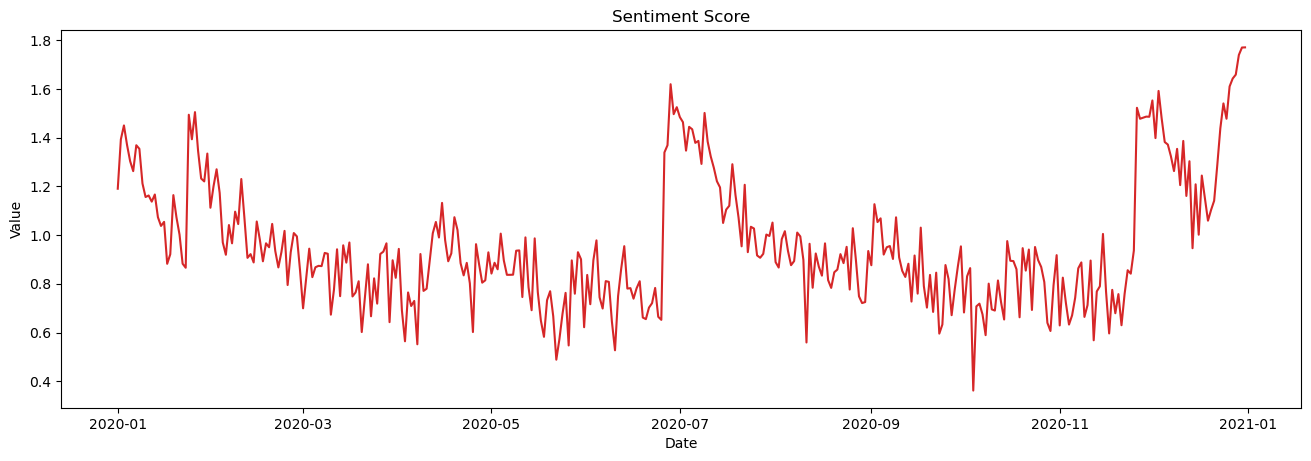

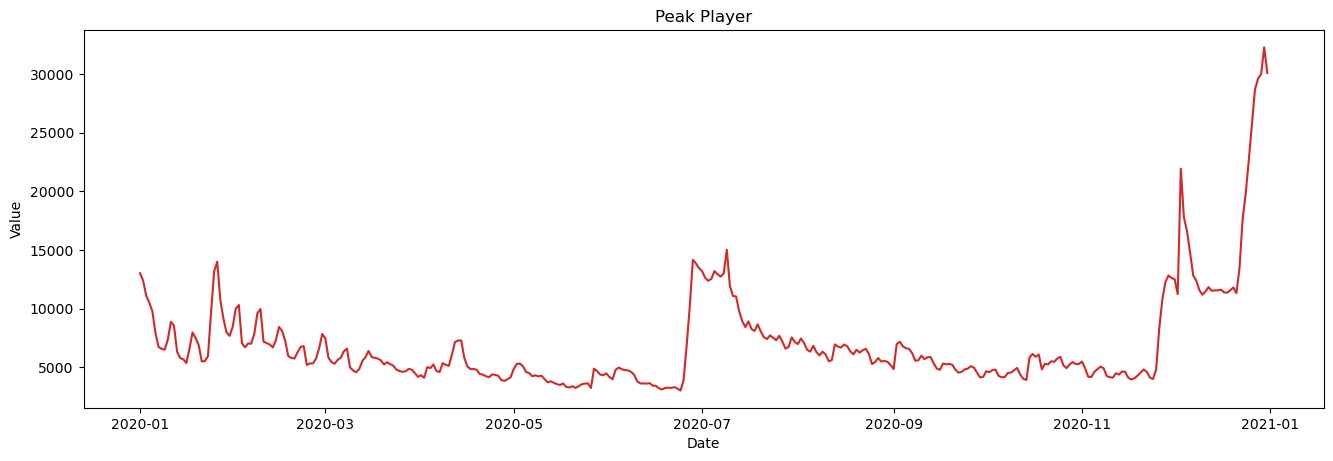

In [25]:
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot

#https://www.analyticsvidhya.com/blog/2021/08/granger-causality-in-time-series-explained-using-chicken-and-egg-problem/
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df.index, y=df.sentscore, title='Sentiment Score')   
plot_df(df, x=df.index, y=df.peakplayer, title='Peak Player')

<t>Augmented Dickey-Fuller</t>

In [5]:
def adf_test(timeseries):
    print ('Dickey-Fuller Test')
    # AIC aims to minimize corresponding information
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    pvalue = dfoutput['p-value']
   # print("Pvalue:" , type() "{:f}".format())
    print (dfoutput)
    
    if pvalue < 0.05: 
        print('Time series is stationary')
    else:
        print('Time series is NOT stationary')

In [6]:
def kpps_test(timeseries):
    print ('KPPS Test')
    #sm.tsa.stattools.kpss(timeseries, regression='ct')
    print("pvalue :",sm.tsa.stattools.kpss(timeseries, regression='ct')[1])
    if sm.tsa.stattools.kpss(timeseries, regression='ct')[1] > 0.05:
      print('Time series is stationary')
    else:
      print('Time series is NOT stationary')


<p>
Vector autoregressive models are used when you want to predict multiple time series using one model. This differs from ARIMA in that we will have to check for stationarity on our own. We will make the data stationary and then invert it back to its original form.
</p>

<p>
We'll use AIC to measure our model. As the model increases in complexity it will get more accurate up to a point where AIC will punish that complexity
</p>

<t>z score because we have two different dataset with two different ranges</t>
<t style="color:red;">NOT NEEDED ANYMORE</t>

            sentscore  peakplayer
datetime                         
2020-01-01  -0.483625    0.903568
2020-01-02   1.761395    0.009174
2020-01-03   1.762154    0.044748
2020-01-04   0.827301    0.647922
2020-01-05   0.859954    0.414482
...               ...         ...
2020-12-27   0.250244    1.133008
2020-12-28   0.977650    0.883887
2020-12-29   0.642880    0.778323
2020-12-30  -0.354309    0.774640
2020-12-31   0.989188    0.403010

[366 rows x 2 columns]


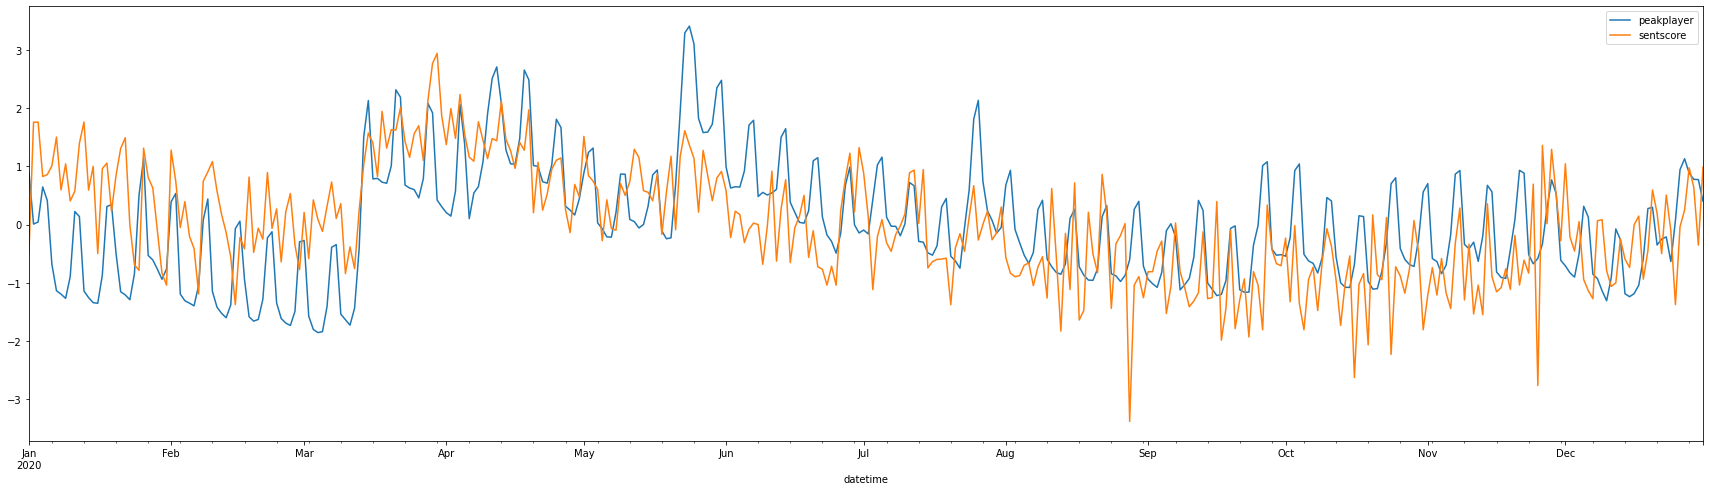

In [196]:
from scipy.stats import zscore
import pandas as pd

df = df.copy(deep=True)

# Calculate the zscores and drop zscores into new column
df['peakplayer'] = zscore(df['peakplayer'])
df['sentscore'] = zscore(df['sentscore'])

ax = df['peakplayer'].plot(legend=True, figsize=(30,8))
df['sentscore'].plot(legend=True)

print(df)

In [247]:
print('sentscore causes peakplayer?\n')
print('------------------')
granger_1 = grangercausalitytests(df[['peakplayer', 'sentscore']], 20)
#lags displayed here is suggestion on at what point you should select the lag, for both lag, choose less than 0.05

print('\npeakplayer causes sentscore\n')
print('------------------')
granger_2 = grangercausalitytests(df[['sentscore', 'peakplayer']], 20)

sentscore causes peakplayer?

------------------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2843  , p=0.5942  , df_denom=362, df_num=1
ssr based chi2 test:   chi2=0.2867  , p=0.5923  , df=1
likelihood ratio test: chi2=0.2866  , p=0.5924  , df=1
parameter F test:         F=0.2843  , p=0.5942  , df_denom=362, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4761  , p=0.6216  , df_denom=359, df_num=2
ssr based chi2 test:   chi2=0.9654  , p=0.6171  , df=2
likelihood ratio test: chi2=0.9641  , p=0.6175  , df=2
parameter F test:         F=0.4761  , p=0.6216  , df_denom=359, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.4227  , p=0.2358  , df_denom=356, df_num=3
ssr based chi2 test:   chi2=4.3520  , p=0.2259  , df=3
likelihood ratio test: chi2=4.3261  , p=0.2283  , df=3
parameter F test:         F=1.4227  , p=0.2358  , df_denom=356, df_num=3

Granger Causality
number of lags (no zero) 4

In [7]:
#granger causality that shows in table (easier to display)

from statsmodels.tsa.stattools import grangercausalitytests

maxlag = 20
def granger(data):
    variables=data.columns  
    matrix = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for col in matrix.columns:
        for row in matrix.index:
            test_result = grangercausalitytests(data[[row, col]], maxlag=maxlag, verbose=False)            
            p_values = [round(test_result[i+1][0]['ssr_chi2test'][1],4) for i in range(maxlag)]            
            min_p_value = np.min(p_values)
            matrix.loc[row, col] = min_p_value
    matrix.columns = [var + '_x' for var in variables]
    matrix.index = [var + '_y' for var in variables]
    print(matrix)

In [48]:
granger(df)

              sentscore_x  peakplayer_x
sentscore_y        1.0000           0.0
peakplayer_y       0.0012           1.0


In [146]:
granger(dfDiff)

              sentscore_x  peakplayer_x
sentscore_y        1.0000           0.0
peakplayer_y       0.0216           1.0


<t>Check for Data Stationary</t>

In [8]:
def checkStationary(df):
    #if one is not stationary, and the other one is stationary, difference is required regardless
    print("----------------------------ADF----------------------------------")
    adf_test(df['peakplayer'])
    print("------------")
    adf_test(df['sentscore'])

    print("----------------------------KPSS----------------------------------")
    kpps_test(df['peakplayer'])
    print("------------")
    kpps_test(df['sentscore'])

In [9]:
#if data is already stationary (FOR STELLARIS ONLY)
def stationaryStellaris(df):
    dfDiff = df.copy()
    
    return dfDiff

In [10]:
# Difference the data
def makeStationary(df):
    dfDiff = df.diff()
    # Delete NaNs
    dfDiff = dfDiff.dropna()

    ax = dfDiff['peakplayer'].plot(legend=True, figsize=(10,4))
    dfDiff['sentscore'].plot(legend=True)

    return dfDiff

<t>Train and Test</t>

In [695]:
print(dfDiff)

              sentscore  peakplayer
datetime                           
2020-01-02  5268.502679     -8498.0
2020-01-03     1.779822       338.0
2020-01-04 -2193.865537      5731.0
2020-01-05    76.629330     -2218.0
2020-01-06   351.953226    -10428.0
...                 ...         ...
2020-12-27   673.227054      1781.0
2020-12-28  1707.039229     -2367.0
2020-12-29  -785.620940     -1003.0
2020-12-30 -2340.153178       -35.0
2020-12-31  3152.851876     -3531.0

[365 rows x 2 columns]


In [11]:
#try without zscore
def trainsplit(dfDiff):
    train_df = dfDiff[:int(0.8*(len(dfDiff)))]
    test_df = dfDiff[int(0.8*(len(dfDiff))):]

    return train_df,test_df

In [12]:
def modeling(train_df):
    mod = VAR(train_df)
    sorted_order=mod.select_order(maxlags=20)
    lag = sorted_order.aic
    print("Lag is: " , lag)
    res = mod.fit(lag)
    return res , lag # <--- number here based on AIC
    # We see results for all pieces of data. As we can see productivity matches up
    # well with GDP
    #res.summary()

<t>MODEL WITH PICKLE</t>

<t>Plotting</t>

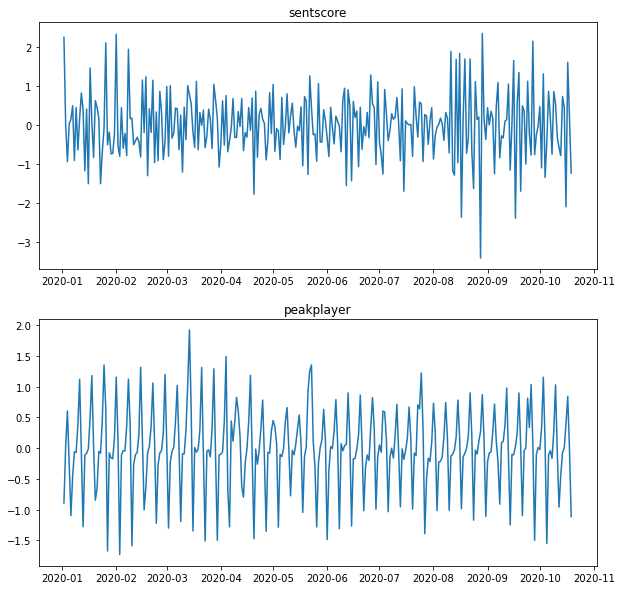

In [730]:
res.plot();

<t>Forecasting</t>

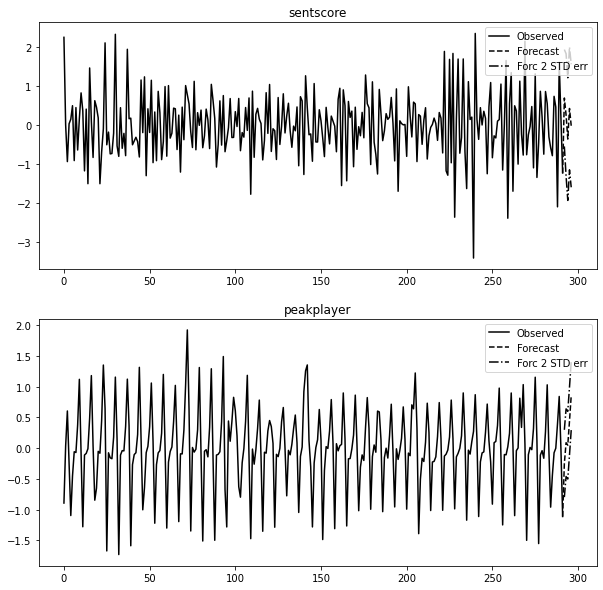

In [731]:
# When forecasting we define how many steps ahead to forecast. We also pass an array
# with p, the lag order, k, the number of time series terms (gdp & prod). We have to
# pass the 4 passed values before the test set begins.

# Produce the forecast
# Values returns a Numpy array

#value inside [] based on lag ; ,4 based on how many we want to predict

#use dfDiff IF YOU WANT TO FORECAST. where this value will be used to concat when differencing
forecast_res = res.forecast(dfDiff.values[-lag:], 50) #30 as in 30 days.

# Plot the forecast
res.plot_forecast(5);

<t>Create test forecasted dataframe</t>

In [13]:
def setDate(test_df):
    getLastDate = test_df.index[len(test_df)-1]
    getstartDate = test_df.index[0]

    durationDays = (getLastDate - getstartDate) 
    durationDays = durationDays.days + 1

    return durationDays 

In [14]:
def createTestSet(test_df,res,train_df,lag):
    durationDays = setDate(test_df)

    #use train_df IF YOU WANT TO SEE YOUR DIFFERENCE BETWEEN TEST AND ACTUAL RESULT, because we want to forecast at the end of the train date.
    #duration days from user input, meaning date to forecast minus start date obtained from dataset. and date to forecast must begin on current date.

    #keep the lag because its a must based on the aic found
    test_res = res.forecast(train_df.values[-lag:], durationDays)

    #meaning the input, must start from the very last date the database have, and minused.
    #therefore, dropna is always needed
    startDate = test_df.index[0].strftime("%Y-%m-%d")

    indx = pd.date_range(startDate, periods=durationDays)

    forecastTest_df = pd.DataFrame(test_res, index=indx,
                          columns=[ 'f_sentscore','f_peakplayer'])

    return forecastTest_df 

<t>Compare train and test dataset</t>

In [15]:
def compareForecastResult(forecastTest_df,test_df):
    test_vs_predScore=pd.concat([test_df.peakplayer,forecastTest_df.f_peakplayer],axis=1)
    test_vs_predScore.plot(legend=True, figsize=(12,5))


<t>Setup Dataframe with Forecast Data (not the tested data) </t>

In [736]:
#indx = pd.date_range('startdate', periods=how long you want to forecast)
#***startdate is not to insert any date, you need to identify when it actually begin to forecast. Because this dataset will be used to concat with the original dataset
#*** therefore, startdate should be 2021-01-01, right after the end of my dataset 2020-12-31
indx = pd.date_range('2021-01-01', periods=50) #periods is the same value you insert when predicting
# Provide frequency data, index and columns
forecast_df = pd.DataFrame(forecast_res, index=indx,
                          columns=['f-sentscore','f-peakplayer'])
print("Forecasted values")                          
print(forecast_df)

print("Actual values values")   
print(dfDiff)

Forecasted values
            f-sentscore  f-peakplayer
2021-01-01  -280.767083   3204.147217
2021-01-02   848.890678   4920.839781
2021-01-03  1745.044342  -1664.835794
2021-01-04 -3765.700708  -5834.850777
2021-01-05  1417.088545  -1671.136531
2021-01-06  -379.391366   -789.120861
2021-01-07 -5127.345087  -4563.217512
2021-01-08  2249.581036   3895.610307
2021-01-09  1568.936550   6095.635980
2021-01-10 -1459.052376  -1178.534178
2021-01-11  -341.329493  -4258.732859
2021-01-12  1790.533266  -1248.896421
2021-01-13   114.380606   -849.052397
2021-01-14 -2248.927892  -3187.411911
2021-01-15   964.464985   3908.283761
2021-01-16  2444.099613   6243.004359
2021-01-17   -18.241392   -514.660651
2021-01-18 -2314.933993  -4141.734073
2021-01-19   434.097694   -651.336127
2021-01-20  1052.267747   -397.571519
2021-01-21 -3253.763115  -3035.075601
2021-01-22   409.702932   3812.506228
2021-01-23  3458.123558   6288.370512
2021-01-24  -649.315764   -642.428597
2021-01-25 -1289.290199  -4018.4

<t>FROM THIS POINT OUT, IS FOR MAPE</t>

In [16]:
def trainsplitNoDiff(df):

    train_dfNotdiff = df[:int(0.8*(len(df)))]
    test_dfNotdiff = df[int(0.8*(len(df))):]  #FOR STELARIS USE THIS

    return train_dfNotdiff,test_dfNotdiff


<t>No need to focus about this coding down here</t>

In [343]:
#USE THIS VALUE FOR BEGINNING OF CALCULATION


#The value of test (1st value inside test dataset) can be obtained via undifferencing the train dataset. (THIS CODING)

#res.forecast(dfDiff.values[-lag:], 50) #30 as in 30 days. eg, you need to undiff the dfDiff, to get 1st value of predicted.

x, x_diff = train_dfNotdiff['peakplayer'].iloc[0], train_df['peakplayer'].iloc[0:]
n_gdp_df = pd.DataFrame(np.r_[x, x_diff].cumsum().astype(float))
value = n_gdp_df.iloc[len(n_gdp_df)-1]

#or why not just obtain the undifferenced train dataset

In [763]:
value = test_dfNotdiff.peakplayer[0] #value should be same as the value of first date of test data

#USE THIS CODING TO UNDIFFERENCE FORECASTED VALUE
#value must be obtained for ml model, because the 1st value before predicting is the value required for cumsum.

#therefore, to obtain this,
t1, t2 = value, test_df['peakplayer'].iloc[0:]
undifferencedTest = pd.DataFrame(np.r_[t1, t2 ].cumsum().astype(float)) 

In [ ]:
value = test_dfNotdiff.peakplayer[0] #value should be same as the value of first date of test data

t1, t2 = value, forecastTest_df['f_peakplayer'].iloc[0:]
undifferencedForecast = pd.DataFrame(np.r_[t1, t2 ].cumsum().astype(float)) #undifferencedForecast

<t>Focus here</t>

In [743]:
gameName = "BloonsTD"

In [17]:
#-------------------#use this one for the non decimal player-------------------------

def undifferenceForecast(test_df,test_dfNotdiff,forecastTest_df):
    value = test_dfNotdiff.peakplayer[0] 

    #therefore, to obtain this,
    t1, t2 = value, test_df['peakplayer'].iloc[0:]
    undifferencedTestNoD = pd.DataFrame(np.r_[t1, t2 ].cumsum().astype(float)) 


    t1, t2 = value, forecastTest_df['f_peakplayer'].iloc[0:]
    undifferencedForecastNoD  = pd.DataFrame(np.r_[t1, t2 ].cumsum().astype(float)) #undifferencedForecast

    return undifferencedForecastNoD,undifferencedTestNoD

<AxesSubplot:>

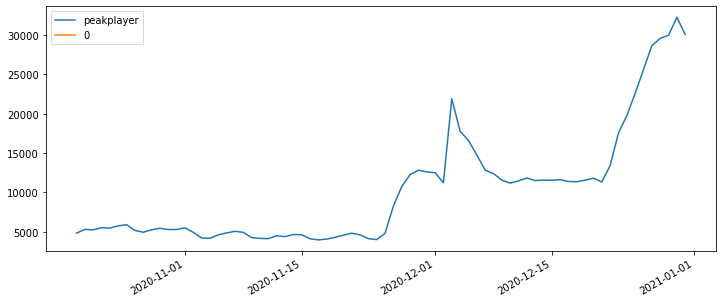

In [808]:
test_vs_predScore=pd.concat([test_dfNotdiff.peakplayer,undifferencedForecast.iloc[:,0]],axis=1)
test_vs_predScore.plot(legend=True, figsize=(12,5))

In [813]:
#ths is to see if not doing undifferencing will affect result
forecast = np.array(forecastTest_df.f_peakplayer)
actual = np.array(test_df.peakplayer) 

In [670]:
#--------------------#

In [692]:
#USE THIS VALUE FOR MAPE!!! THE DATA MUST NOT BE IN DECIMAL POINTS
actual = np.array(test_dfNotdiff[1:].peakplayer) 
forecast = np.array(undifferencedForecastNoD.iloc[1:,0]) 

In [672]:
forecast = np.array(undifferencedTestNoD.iloc[1:,0])
actual = np.array(test_dfNotdiff[1:].peakplayer) 

In [989]:
gameName = "Stellaris"

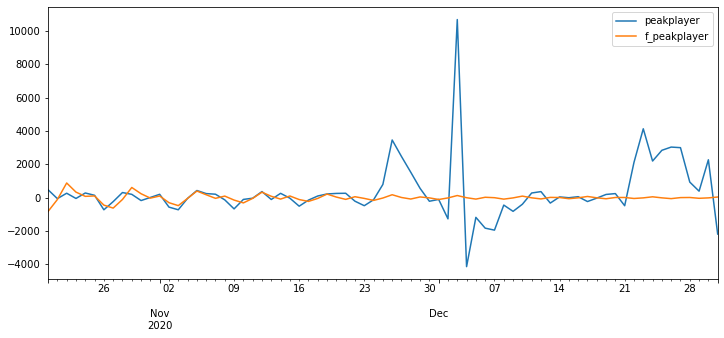

In [30]:
compareForecastResult(forecastTest_df,test_df)
trainsplitNoDiff(dfDiff)

In [93]:
name = "Stellaris"
gameName = "consolidated" + name + "-NotPredicted.xls" 

----------------------------ADF----------------------------------
Dickey-Fuller Test
Test Statistic                  -3.183925
p-value                          0.020934
#Lags Used                      15.000000
Number of Observations Used    350.000000
dtype: float64
Time series is stationary
------------
Dickey-Fuller Test
Test Statistic                  -5.268806
p-value                          0.000006
#Lags Used                       2.000000
Number of Observations Used    363.000000
dtype: float64
Time series is stationary
----------------------------KPSS----------------------------------
KPPS Test
pvalue : 0.06921990246167407
Time series is stationary
------------
KPPS Test
pvalue : 0.08699023298207599
Time series is stationary


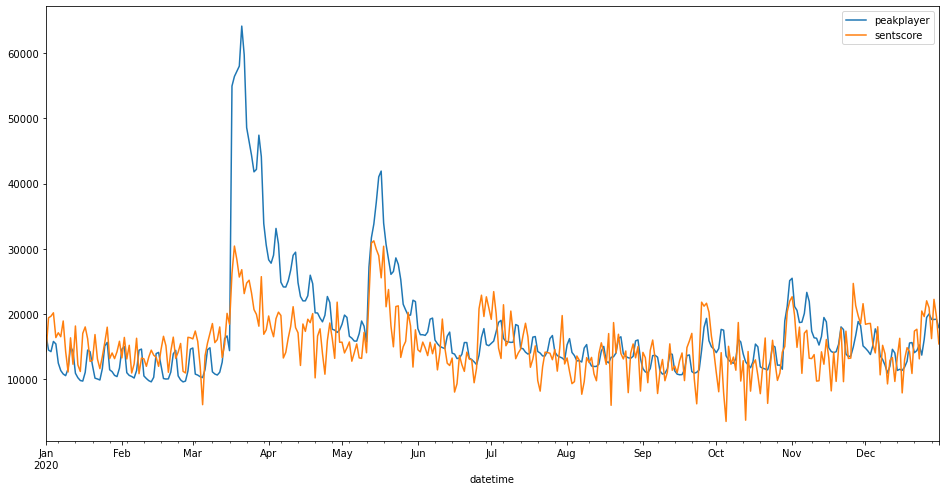

In [94]:
df = readData(gameName)

checkStationary(df)

In [95]:
dfDiff = stationaryStellaris(df)
checkStationary(dfDiff)

----------------------------ADF----------------------------------
Dickey-Fuller Test
Test Statistic                  -3.183925
p-value                          0.020934
#Lags Used                      15.000000
Number of Observations Used    350.000000
dtype: float64
Time series is stationary
------------
Dickey-Fuller Test
Test Statistic                  -5.268806
p-value                          0.000006
#Lags Used                       2.000000
Number of Observations Used    363.000000
dtype: float64
Time series is stationary
----------------------------KPSS----------------------------------
KPPS Test
pvalue : 0.06921990246167407
Time series is stationary
------------
KPPS Test
pvalue : 0.08699023298207599
Time series is stationary


----------------------------ADF----------------------------------
Dickey-Fuller Test
Test Statistic                -5.956402e+00
p-value                        2.088254e-07
#Lags Used                     1.600000e+01
Number of Observations Used    3.480000e+02
dtype: float64
Time series is stationary
------------
Dickey-Fuller Test
Test Statistic                 -21.101778
p-value                          0.000000
#Lags Used                       1.000000
Number of Observations Used    363.000000
dtype: float64
Time series is stationary
----------------------------KPSS----------------------------------
KPPS Test
pvalue : 0.1
Time series is stationary
------------
KPPS Test
pvalue : 0.1
Time series is stationary


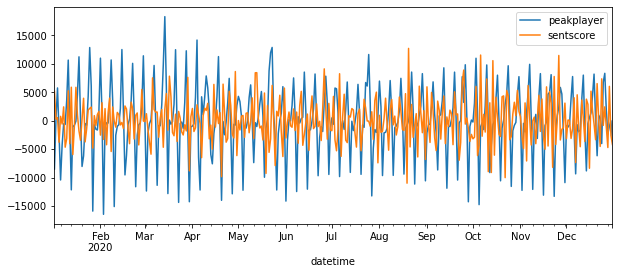

In [86]:
dfDiff = makeStationary(df)
checkStationary(dfDiff)

In [96]:
granger(dfDiff)

              sentscore_x  peakplayer_x
sentscore_y         1.000           0.0
peakplayer_y        0.018           1.0


Lag is:  8


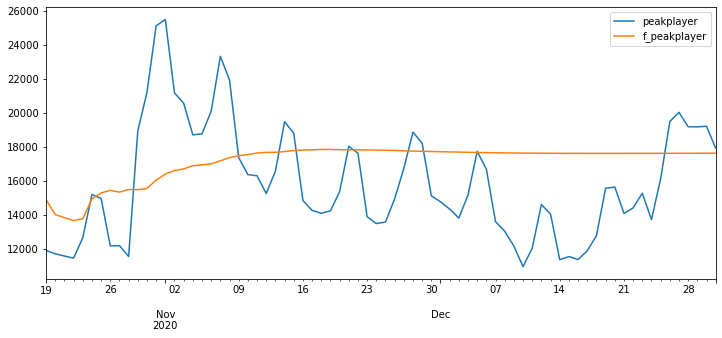

In [97]:
train_df,test_df = trainsplit(dfDiff)

res,lag = modeling(train_df)

forecastTest_df = createTestSet(test_df,res,train_df, lag)

compareForecastResult(forecastTest_df,test_df)

In [90]:
train_dfNotdiff, test_dfNotdiff = trainsplitNoDiff(df)

Lag is:  8


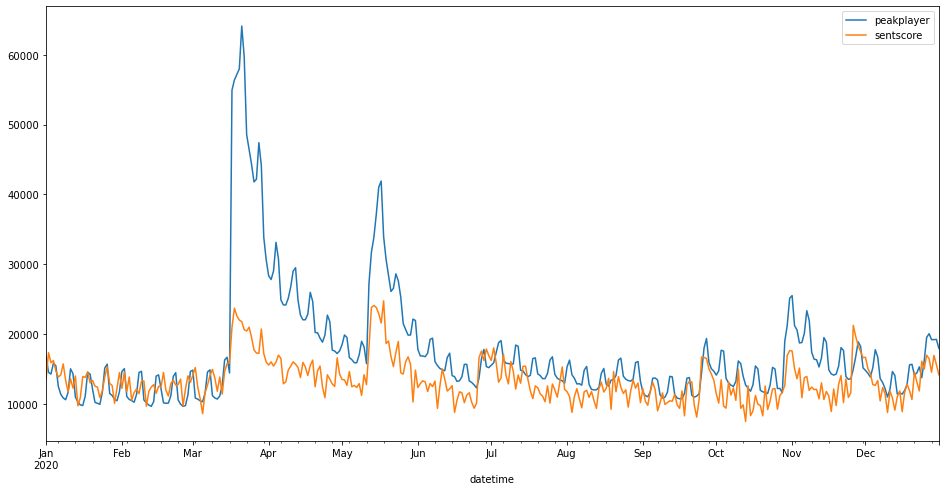

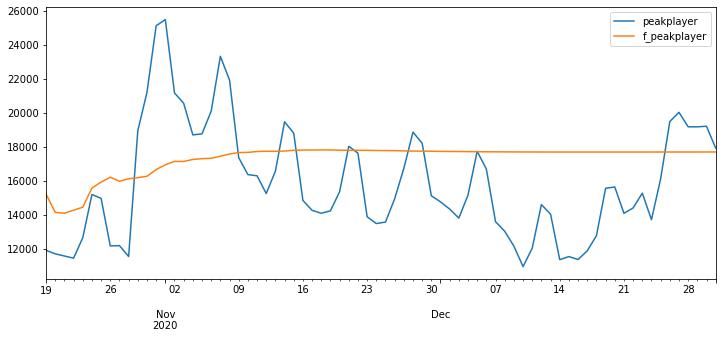

In [990]:
df = readData(gameName)

# checkStationary(df)

#dfDiff = makeStationary(df)

stationaryStellaris(df)

train_df,test_df = trainsplit(dfDiff)

res,lag = modeling(train_df)

forecastTest_df = createTestSet(test_df,res,train_df, lag)

compareForecastResult(forecastTest_df,test_df)

train_dfNotdiff, test_dfNotdiff = trainsplitNoDiff(df)

In [91]:
#NOTE THIS IS THE MAIN RESULT TO BE OBTAINED
undifferencedForecast, undifferencedTest = undifferenceForecast(test_df,test_dfNotdiff,forecastTest_df)

MAPE(test_dfNotdiff,undifferencedForecast)



    MAPE   : 0.13
    MAPE % : 12.55 %
    


In [98]:
#NOTE: undifferenced test is only to see if test and test no diff is 0%
MAPE(test_dfNotdiff,undifferencedTest)


    MAPE   : 0.0
    MAPE % : 0.0 %
    


In [99]:
#NOTE: FOR STELARIS, NO NEED TO USE UNDIFFERNCE DATA, JUST NORMAL TEST AND FORECAST DF

stelaris = True
MAPE(test_df,forecastTest_df, stelaris)


    MAPE   : 0.2
    MAPE % : 20.46 %
    


            actual    forecasted
2020-10-20   33987  30832.786500
2020-10-21   34060  33485.191106
2020-10-22   36918  31233.193290
2020-10-23   41588  35896.722915
2020-10-24   51214  44457.246314
...            ...           ...
2020-12-27   55295  43003.593945
2020-12-28   52928  35702.926248
2020-12-29   51925  33033.926927
2020-12-30   51890  33978.437433
2020-12-31   48359  33411.421787

[73 rows x 2 columns]


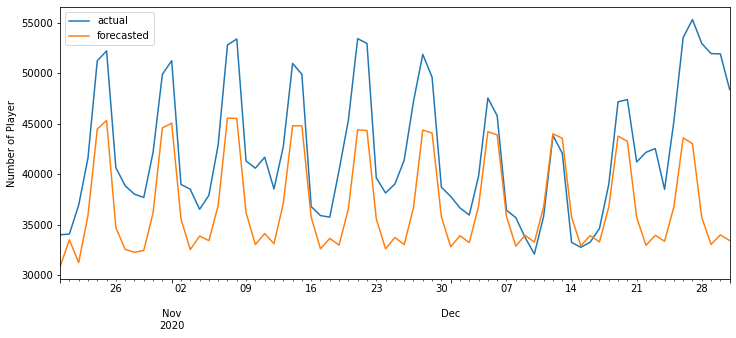

In [92]:
visualize(undifferencedForecast, test_dfNotdiff, test_df)

In [49]:
def MAPE(test_dfNotdiff,undifferenced, stelaris = False):

    if stelaris == False: #need to start at one because test starts at 20
        actual = np.array(test_dfNotdiff[1:].peakplayer) 
        forecast = np.array(undifferenced.iloc[1:,0]) 
    else:#stellaris starts at 19
        actual = np.array(test_dfNotdiff[0:].peakplayer) 
        forecast = np.array(undifferenced.iloc[0:,1]) 

    APE = []
    
    # Iterate over the list values
    for day in range(len(actual)):
    
        # Calculate percentage error
        per_err = (actual[day] - forecast[day]) / actual[day]
    
        # Take absolute value of
        # the percentage error (APE)
        per_err = abs(per_err)
    
        # Append it to the APE list
        APE.append(per_err)
    
    # Calculate the MAPE
    MAPE = sum(APE)/len(APE)
    
    # Print the MAPE value and percentage
    print(f'''
    MAPE   : { round(MAPE, 2) }
    MAPE % : { round(MAPE*100, 2) } %
    ''')

In [48]:
def visualize(forecasted, actualValue, test_df,  stelaris = False):
    durationDays = setDate(test_df)
    if stelaris == False: #need to start at one because test starts at 20
        actual = np.array(actualValue[1:].peakplayer) 
        forecast = np.array(forecasted.iloc[1:,0]) 

    else:#stellaris starts at 19
        actual = np.array(actualValue[0:].peakplayer) 
        forecast = np.array(forecasted.iloc[0:,0]) 

    startDate = test_df.index[0].strftime("%Y-%m-%d")

    indx = pd.date_range(startDate, periods=durationDays)

    result = pd.DataFrame(index=indx)


    result['actual'] = actual
    result['forecasted'] = forecast

    print(result)

    result.plot(figsize=(12,5)).set_ylabel("Number of Player")